In [18]:
%load_ext autoreload
%autoreload 2

import scanpy as sc
import yaml
import json
import os
import sys
sys.path.append('../')
sys.path.append('../external/hovernet')
sys.path.append('../hedest')

PATH = '/home/luca/Documents/data/'
# '/cluster/CBIO/data1/lgortana/'
# '/home/luca/Documents/data_CBIO/'
# '/home/luca/Documents/data/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ground truth

In [19]:
import torch

#load adata
adata_name = 'Xenium_FFPE_Human_Breast_Cancer_Rep1'
data_path = os.path.join(PATH, adata_name)
path_ST_adata = os.path.join(data_path, f'sim_3types/pseudo_adata_real.h5ad')
adata = sc.read_h5ad(path_ST_adata) #read_visium or read_h5ad

#image path
image_path = os.path.join(data_path, 'pyr_tif/Xenium_FFPE_Human_Breast_Cancer_Rep1_he_image.tif')
image_dict = torch.load(os.path.join(data_path, "image_dict_64.pt"))

#load image infos
gt_json_path = os.path.join(data_path, f'sim_3types/pannuke_fast_mask_lvl3_annotated.json')
with open(gt_json_path) as json_file:
    gt_seg_dict = json.load(json_file)

In [20]:
import pandas as pd

#load spot proportions
spot_prop_df = pd.read_csv(os.path.join(data_path, f'sim_3types/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_prop_real.csv'), index_col=0)
spot_prop_df.index = spot_prop_df.index.astype(str)
ct_list = list(spot_prop_df.columns)

#load spot dict
with open(os.path.join(data_path, f'sim_3types/spot_dict_real.json'), "r") as file:
    spot_dict = json.load(file)

#load cell predictions
gt = pd.read_csv(os.path.join(data_path, f'sim_3types/sim_Xenium_FFPE_Human_Breast_Cancer_Rep1_gt.csv'), index_col=0)
gt.index = gt.index.astype(str)

In [21]:
color_dict = {
    '0': ['neopla', [31, 119, 180, 255]],
    '1': ['inflam', [0, 170, 140, 255]],
    '2': ['connec', [255, 140, 0, 255]]
}

color_dict_all = color_dict.copy()
color_dict_all[f'{len(ct_list)}'] = ['unlabeled', [0, 0, 0, 255]]
color_dict_all[f'{len(ct_list)+1}'] = ['no_match', [170, 170, 170, 255]]

In [22]:
from hedest.analysis.postseg import count_cell_types
count_cell_types(gt_seg_dict, [item[0] for item in list(color_dict_all.values())])

,no_match,neopla,connec,unlabeled,inflam
0,48070,48365,45147,6438,27184


In [6]:
from hedest.analysis.postseg import StdVisualizer

plotter_gt = StdVisualizer(image_path=image_path,
                        adata=adata,
                        adata_name=adata_name,
                        seg_dict=gt_seg_dict,
                        color_dict=color_dict_all)

Visium data found.


In [7]:
plotter_gt.original_size

(11580, 45087)

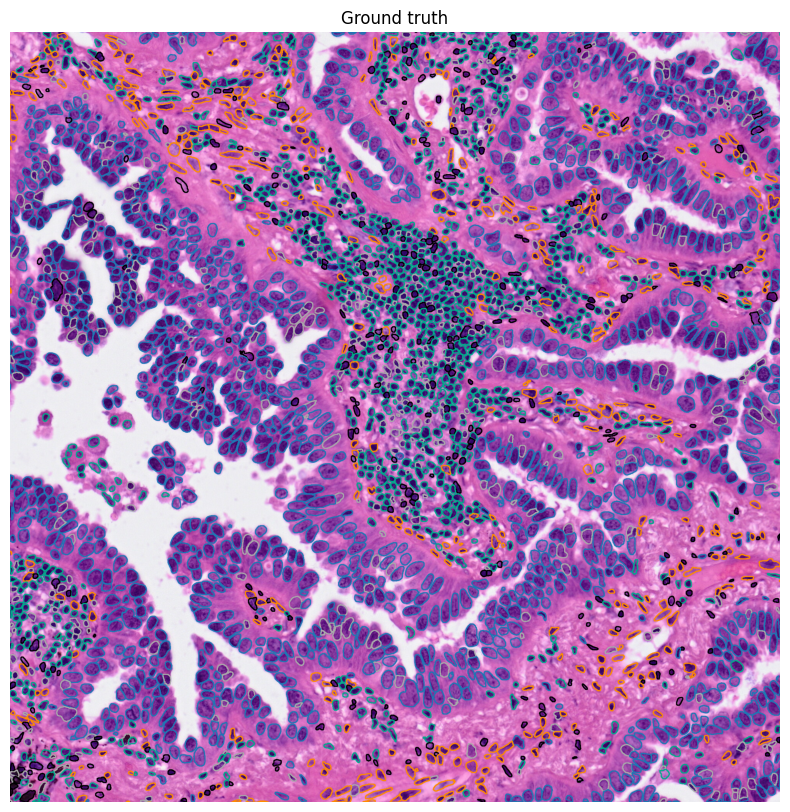

In [15]:
window = ((4500, 14500), (2000, 2000))
plotter_gt.plot_seg(window=window, show_visium=False, title='Ground truth', display=True, figsize=(10, 10))
# fig.savefig(f"../results/HoVerNet/{adata_name}/crop_3types_gt_17000_17000_1500.png", dpi=300, bbox_inches='tight')

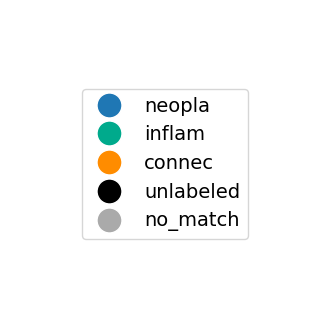

In [9]:
from hedest.analysis.plots import plot_legend

plot_legend(color_dict_all)

# HEDeST predictions

In [10]:
import pickle

#load model infos
model_tag = 'model_quick_alpha_0.0_lr_0.0003_divergence_l2_beta_0.0_seed_8'
model_dir = os.path.join(f'results/HoVerNet/{adata_name}/HEDeST/3types', model_tag)

with open(os.path.join(model_dir, 'info.pickle'), 'rb') as f:
    model_info = pickle.load(f)

In [11]:
from hedest.analysis.pred_analyzer import PredAnalyzer

analyzer_dp = PredAnalyzer(model_info=model_info,
                        adjusted=True,
                        ground_truth=gt, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


In [12]:
pd.DataFrame(analyzer_dp.proportions.mean(axis=0)).T

,neopla,inflam,connec
0,0.610976,0.182945,0.206079


In [13]:
analyzer_dp.add_attributes(adata=adata,
                        adata_name=adata_name,
                        image_path=image_path,
                        seg_dict=gt_seg_dict)

In [14]:
from hedest.analysis.postseg import StdVisualizer

plotter_dp = StdVisualizer(image_path, 
                        adata, 
                        adata_name, 
                        seg_dict=analyzer_dp.seg_dict_w_class,
                        color_dict=color_dict)

Visium data found.


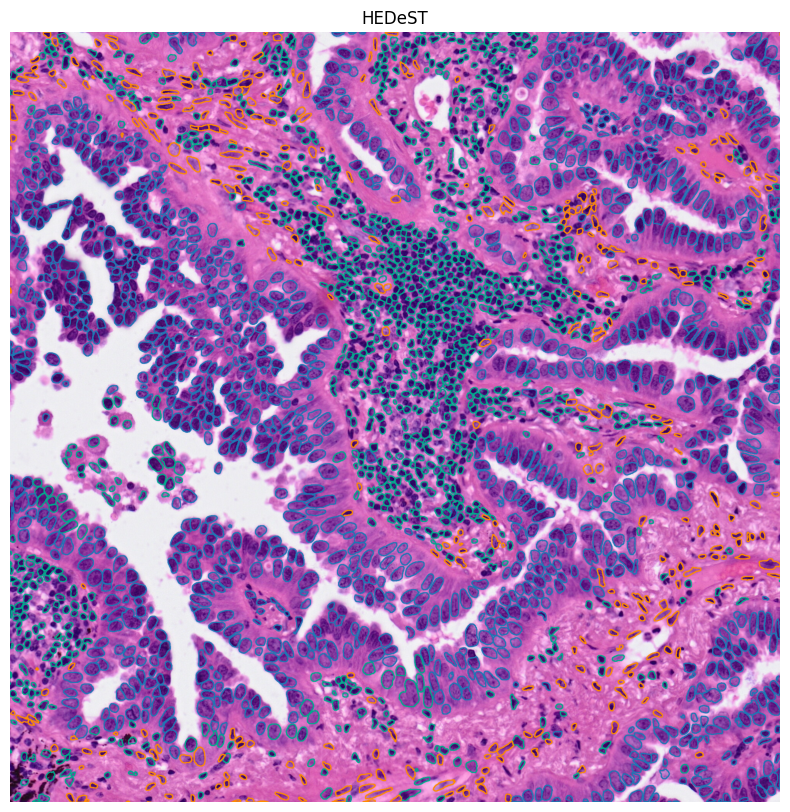

In [16]:
window = ((4500, 14500), (2000, 2000)) #((4500, 14500), (2000, 2000))
plotter_dp.plot_seg(window=window, show_visium=False, title='HEDeST', display=True, figsize=(10, 10))
# fig.savefig(f"results/HoVerNet/{adata_name}/crop_3types_hedest_17000_17000_1500.png", dpi=300, bbox_inches='tight')

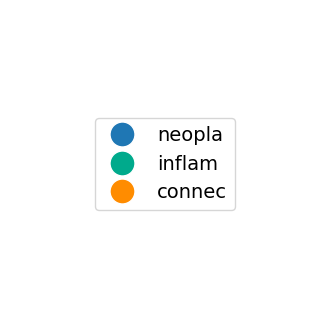

In [16]:
plot_legend(color_dict, savefig=f"results/HoVerNet/{adata_name}/fig/legend_3_types.png")

# HoVerNet pre-classification

In [23]:
#load original hovernet segmentation
hovernet_json_path = os.path.join(data_path, f'seg_json/pannuke_fast_mask_lvl3.json')
with open(hovernet_json_path) as json_file:
    hovernet_seg_dict = {'mag': None,
                         'nuc': {str(i): v for i, (k, v) in enumerate(json.load(json_file)['nuc'].items())}}
    
dict_types_path = "../references/colors_hovernet.yaml"
with open(dict_types_path, 'r') as file:
    dict_types = yaml.load(file, Loader=yaml.FullLoader)["pannuke"]

In [24]:
cell_types = {int(k): v[0] for k, v in dict_types.items()}

rows = []
for cell_id, cell_info in hovernet_seg_dict['nuc'].items():
    type_id = cell_info['type']
    row = {cell_type: 0 for cell_type in cell_types.values()}
    row[cell_types[type_id]] = 1
    row['nucleus_id'] = cell_id
    rows.append(row)

hn_preds = pd.DataFrame(rows).set_index('nucleus_id')

In [25]:
#remove necros and no-neo cells from the predictions
hn_preds = hn_preds[(hn_preds['necros'] == 0) & (hn_preds['no-neo'] == 0) & (hn_preds['nolabe'] == 0)]
hn_preds = hn_preds.drop(columns=['necros', 'no-neo', 'nolabe'])

In [26]:
#keep intersection of indices
common_indices = gt.index.intersection(hn_preds.index)
filtered_gt = gt.loc[common_indices]
filtered_hn_preds = hn_preds.loc[common_indices]

In [ ]:
# common_indices.to_series().to_csv(os.path.join(data_path, 'sim_3types', 'LuCA', 'remaining_cells_hn.csv'), index=False)

In [27]:
from hedest.analysis.pred_analyzer import PredAnalyzer

preds = {'pred_best': filtered_hn_preds}

analyzer = PredAnalyzer(preds=preds,
                        spot_dict=spot_dict,
                        adjusted=False,
                        ground_truth=filtered_gt, 
                        image_dict=image_dict
                        )

Loading predicted labels...
Loading true labels...
Use `add_attributes(history=your_history)` to add one.
Use `add_attributes(seg_dict=your_seg_dict)` to add one.


In [28]:
analyzer.add_attributes(adata=adata,
                        adata_name=adata_name,
                        image_path=image_path,
                        seg_dict=hovernet_seg_dict)

In [29]:
from hedest.analysis.postseg import StdVisualizer

plotter_hn = StdVisualizer(image_path, 
                        adata, 
                        adata_name, 
                        seg_dict=analyzer.seg_dict_w_class,
                        color_dict=color_dict)

Visium data found.


In [31]:
window = ((18405, 14975), (200, 200)) #((3000, 20000), (2000, 2000))
fig = plotter_hn.plot_seg(window=window, show_visium=False, title='HoVerNet', display=False, figsize=(4, 4))
fig.savefig(f"results/HoVerNet/{adata_name}/fig/crop_3types_hn_{window[0][0]}_{window[0][1]}_{window[1][0]}.png", dpi=300, bbox_inches='tight')

In [ ]:
# from benchmark.utils import save_metrics_to_excel

# list_metrics = ['Global Accuracy', 'Balanced Accuracy', 'Weighted F1 Score', 'Weighted Precision', 'Weighted Recall']
# stats = {k:v for k, v in analyzer.evaluate_cell_predictions().items() if k in list_metrics}

# save_metrics_to_excel(stats, 0, f'results/HoVerNet/{adata_name}/metrics.xlsx')